In [1]:
import scipy.constants as scc
from common_functions import *
import pathlib
import os
import time
import numpy as np
from common_functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba_progress import ProgressBar

#Energies
E_i = 200 #in keV
minimum_energy = 0.05 #in keV
t_counting = 80 #in keV

#Material properties
N = scc.physical_constants['Avogadro constant'][0]
Z = 14 #number of protons
A = 28.1 #atomic weight in Daltons
p = 2.33 #density of material in g/cm cubed
dE_threshold = 0.00362 #eh pair generation of material in keV
pixel_dimensions = List(np.around([27.5*10**-4, 27.5*10**-4, 10**-2 + 300*10**-4], decimals=6)) # [x, y, 10**-2 + z] in cm -change, x, y, z only

#Choose electron dose
dose = 1000 #choose fluence/dose in number of electrons; 34376 is number of nonzero in knife edge

#Output file type
ext = '.png'
ext_2 = '.svg'

#images
num_samples = 1 #relative precision = 1/root(n)


#Do not change these
print('\nParameters used in simulation: \n \n', ' Incident energy (keV): ', E_i, '\n  Mininum energy (keV): ', minimum_energy, '\n  Counting threshold (keV): ', t_counting,
      '\n  Electron-hole pair energy threshold (keV): ', dE_threshold, '\n  Z: ', Z, '\n  Atomic weight (u): ', A, '\n  Density (g/cm\N{SUPERSCRIPT THREE}): ', p,
      '\n  Pixel dimensions (cm): ', pixel_dimensions, '\n  Fluence (e): ', dose, '\n  Number of samples: ', num_samples)


Parameters used in simulation: 
 
  Incident energy (keV):  200 
  Mininum energy (keV):  0.05 
  Counting threshold (keV):  80 
  Electron-hole pair energy threshold (keV):  0.00362 
  Z:  14 
  Atomic weight (u):  28.1 
  Density (g/cm³):  2.33 
  Pixel dimensions (cm):  [0.00275, 0.00275, 0.04, ...] 
  Fluence (e):  1000 
  Number of samples:  1


In [2]:


#Main function
@jit(nopython = True, parallel =True)
def MCS_ChargeCounting(E_i, minimum_energy, t_counting, dE_threshold, N, Z, A, p, pixel_dimensions, pixel_information, perfect_image):
    # counters
    number_transmitted = 0
    number_backscattered = 0
    number_stopped = 0
    number_eh_pairs = 0
    new_image_MCS = np.zeros((perfect_image.shape[0], perfect_image.shape[1]), dtype=np.float64)
    for pixel_counter in prange(len(pixel_information)):
            number_of_electrons = int(pixel_information[pixel_counter][0])
            i_coordinate = int(pixel_information[pixel_counter][1])
            j_coordinate = int(pixel_information[pixel_counter][2])
            for _ in prange(1, number_of_electrons + 1):
                eh_charge_counter = np.zeros((perfect_image.shape[0], perfect_image.shape[1]), dtype = np.float64)
                # initial conditions
                alpha = evaluate_alpha(E_i, Z)
                cross = evaluate_cross_section(E_i, Z, alpha)
                path_length = evaluate_path_length(A, N, p, cross)
                RND_step = RND(a=0.000001, b=0.999999)
                step = evaluate_step(path_length = path_length, RND=RND_step)
                ip = initialise_postions(step=step, d = pixel_dimensions[0]) #d = probe diameter
                cx = ip[0]
                cy = ip[1]
                cz = ip[2]
                z0 = ip[3]
                y0 = ip[4]
                x0 = ip[5]
                condition = True
                E = E_i
                while condition: #Monte Carlo Loop until backscatter, trasmission or stopping
                    RND_phi = RND(a=0, b=1)  # generate random number for the phi angle
                    RND_step = RND(a = 0.000001, b = 0.999999)
                    RND_pho = RND(a = 0, b = 1)

                    alpha = evaluate_alpha(E, Z)  # calc screening constant, function of previous energy
                    cross = evaluate_cross_section(E, Z, alpha)  # calc cross section
                    path_length = evaluate_path_length(A, N, p, cross)  # calc mean free path length
                    step = evaluate_step(path_length=path_length, RND=RND_step)  # calculate step of this iteration
                    dE = step * p * evaluate_energy_loss_rate(E, Z, A)
                    E = E + dE  # calc new energy #separate out dE/dS
                    phi = evaluate_phi(RND=RND_phi, alpha=alpha)  # calc scattering angle
                    psi = evaluate_pho(RND=RND_pho)  # calc other scattering angle
                    ca = evaluate_direction_cosine_a(phi, psi, cx, cy, cz)  # calc direction cosines
                    cb = evaluate_direction_cosine_b(phi, psi, cx, cy, cz)
                    cc = evaluate_direction_cosine_c(phi, psi, cz)
                    x0 = x0 + step * ca  # find and reset to new positions
                    y0 = y0 + step * cb
                    z0 = z0 + step * cc
                    cx = ca  # reset direction cosines
                    cy = cb
                    cz = cc
                    if E <= minimum_energy: #if electron stops in the material
                        number_stopped = number_stopped + 1
                        condition = False
                    if z0 < 10**-2: #if electron backscatters
                        number_backscattered = number_backscattered + 1
                        condition = False #not sure how to deal with electron scattering outside of material
                    if z0 > pixel_dimensions[2]:  # if electron penetrates material #change to have de/ds as the counting
                        # thin
                        number_transmitted = number_transmitted + 1
                        condition = False
                    if -1*dE >= dE_threshold: #if electron deposits sufficient energyo
                        new_eh_pairs = math.floor(-1*dE/dE_threshold)
                        number_eh_pairs = int(number_eh_pairs + new_eh_pairs)

                        if (x0 <= 1*pixel_dimensions[0]) and (x0 >= -1*pixel_dimensions[0]) and (y0 <= 1*pixel_dimensions[
                            1])and (y0 >=-1*pixel_dimensions[1]): #electron stays within pixel region

                            eh_charge_counter[i_coordinate, j_coordinate] = new_eh_pairs + eh_charge_counter[i_coordinate, j_coordinate]

                        elif (x0 > 1*pixel_dimensions[0]) and (y0 > 1*pixel_dimensions[1]): #electron moves positively in x
                            # and y
                            translation_x = round_half_down(x = x0/(2*pixel_dimensions[0]))
                            translation_y = round_half_down(x =y0/(2*pixel_dimensions[1]))
                            if i_coordinate + translation_x  <= perfect_image.shape[0] - 1 and j_coordinate + \
                                    translation_y <= perfect_image.shape[0] - 1:
                                    eh_charge_counter[i_coordinate + translation_x, j_coordinate + translation_y] = new_eh_pairs + eh_charge_counter[i_coordinate +translation_x,j_coordinate +translation_y]


                        elif (x0 < -1*pixel_dimensions[0]) and (y0 < -1*pixel_dimensions[1]): #electron moves negatively in x
                            # and y
                            translation_x = round_half_down(x=x0 / (2 * pixel_dimensions[0]))
                            translation_y = round_half_down(x=y0 / (2 * pixel_dimensions[1]))
                            if i_coordinate - translation_x >= 0 and j_coordinate - translation_y >= 0:
                                    eh_charge_counter[i_coordinate - translation_x, j_coordinate - translation_y] =new_eh_pairs + eh_charge_counter[i_coordinate -translation_x,j_coordinate -translation_y]



                        elif x0 > (1*pixel_dimensions[0]) and y0 < (-1*pixel_dimensions[1]):  # electron moves psoitively in
                            # x and negatively in y
                            translation_x = round_half_down(x=x0 / (2 * pixel_dimensions[0]))
                            translation_y = round_half_down(x=y0 / (2 * pixel_dimensions[1]))
                            if j_coordinate - translation_y >= 0 and i_coordinate + translation_x  <= \
                                    perfect_image.shape[0] - 1:
                                    eh_charge_counter[i_coordinate + translation_x, j_coordinate - translation_y] = new_eh_pairs + eh_charge_counter[i_coordinate +translation_x,j_coordinate -translation_y]

                        elif x0 < (-1*pixel_dimensions[0]) and y0 > (1*pixel_dimensions[1]):  # electron moves negatively in
                            # x and positively in y
                            translation_x = round_half_down(x=x0 / (2 * pixel_dimensions[0]))
                            translation_y = round_half_down(x=y0 / (2 * pixel_dimensions[1]))
                            if i_coordinate - translation_x >= 0 and j_coordinate + \
                                    translation_y <= perfect_image.shape[0] - 1:
                                    eh_charge_counter[i_coordinate - translation_x, j_coordinate + translation_y] = new_eh_pairs + eh_charge_counter[i_coordinate -translation_x,j_coordinate +translation_y]

                        elif x0 > (1*pixel_dimensions[0]): #electron moves in positive x direction
                            translation_x = round_half_down(x=x0 / (2 * pixel_dimensions[0]))
                            if i_coordinate + \
                                    translation_x <= perfect_image.shape[0] - 1:

                                    eh_charge_counter[i_coordinate + translation_x, j_coordinate] = new_eh_pairs + eh_charge_counter[i_coordinate +translation_x, j_coordinate]

                        elif x0 < (-1*pixel_dimensions[0]): #electron moves in negative x direction
                            translation_x = round_half_down(x=x0 / (2 * pixel_dimensions[0]))
                            if i_coordinate - translation_x >= 0:

                                    eh_charge_counter[i_coordinate - translation_x, j_coordinate] = new_eh_pairs + eh_charge_counter[i_coordinate -translation_x,j_coordinate]

                        elif y0 > (1*pixel_dimensions[1]): #electron moves in positive y direction
                            translation_y = round_half_down(x=y0 / (2 * pixel_dimensions[1]))
                            if j_coordinate + \
                                    translation_y <= perfect_image.shape[0] - 1:

                                    eh_charge_counter[i_coordinate, j_coordinate + translation_y] = new_eh_pairs + eh_charge_counter[i_coordinate,j_coordinate +translation_y]

                        elif y0 < (-1*pixel_dimensions[0]): #electron moves in negative y direction
                            translation_y = round_half_down(x=y0 / (2 * pixel_dimensions[1]))

                            if j_coordinate - translation_y >= 0:

                                    eh_charge_counter[i_coordinate, j_coordinate - translation_y] = new_eh_pairs + eh_charge_counter[i_coordinate,j_coordinate -translation_y]

                eh_charge_counter = (np.floor(dE_threshold*eh_charge_counter/t_counting))
                new_image_MCS += eh_charge_counter #+ new_image_MCS
    return new_image_MCS




In [3]:
import h5py

# Load the original HDF5 file
input_hdf5_filename = r'/media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/infinite_dose/4DSTEM_infinite.hdf5' # Update with the actual input file path
# Get the parent of the parent folder
parent_folder = os.path.dirname(os.path.dirname(input_hdf5_filename)) + r'/{}_dose'.format(dose)
os.makedirs(parent_folder, exist_ok=True)
doseapplied_hdf5_filename = parent_folder + r'/4DSTEM_B4InFluence.hdf5'
output_hdf5_filename = parent_folder + r'/4DSTEM_InFluence.hdf5'  # Update with the desired output file path


In [4]:
with h5py.File(input_hdf5_filename, "r") as input_hdf5_file, h5py.File(output_hdf5_filename, "w") as output_hdf5_file, h5py.File(doseapplied_hdf5_filename, "w") as doseapplied_hdf5_file:
    # Copy attributes and other metadata
    for attr_name, attr_value in input_hdf5_file.attrs.items():
        print(attr_name, attr_value)
        output_hdf5_file.attrs[attr_name] = attr_value
        doseapplied_hdf5_file.attrs[attr_name] = attr_value
    # Create a new dataset in the output file
    output_dataset = output_hdf5_file.create_dataset("array", shape=input_hdf5_file["array"].shape, dtype=np.uint32)
    doseapplied_output_dataset = doseapplied_hdf5_file.create_dataset("array", shape=input_hdf5_file["array"].shape, dtype=np.uint32)
    # Use tqdm to create a progress bar
    total_iterations = input_hdf5_file["array"].shape[0] * input_hdf5_file["array"].shape[1]
    progress_bar = tqdm(total=total_iterations, desc="Processing Images", unit="image")

    # Iterate through the dataset and apply modulation
    for n in range(input_hdf5_file["array"].shape[0]):
        for m in range(input_hdf5_file["array"].shape[1]):
            original_image = input_hdf5_file["array"][n, m]
            chosen_pixels = find_distribution(original_image, dose)
            perfect_image = num_samples*distribute_electrons(original_image, chosen_pixels)
            pixel_information = get_pixel_info(image = perfect_image)
            pixel_information, _ = make_2D_array(pixel_information)
            modulated_image = np.uint32(MCS_ChargeCounting(E_i, minimum_energy, t_counting, dE_threshold, N, Z, A, p, pixel_dimensions, pixel_information, perfect_image))
            output_dataset[n, m] = modulated_image
            doseapplied_output_dataset[n, m] = perfect_image
            progress_bar.update(1)  # Update the progress bar
            
    progress_bar.close()  # Close the progress bar

print("Modulation and copying completed.")


Processing Images: 100%|████████████████████████████████████████████| 2025/2025 [01:16<00:00, 26.46image/s]

Modulation and copying completed.


<IPython.core.display.Javascript object>


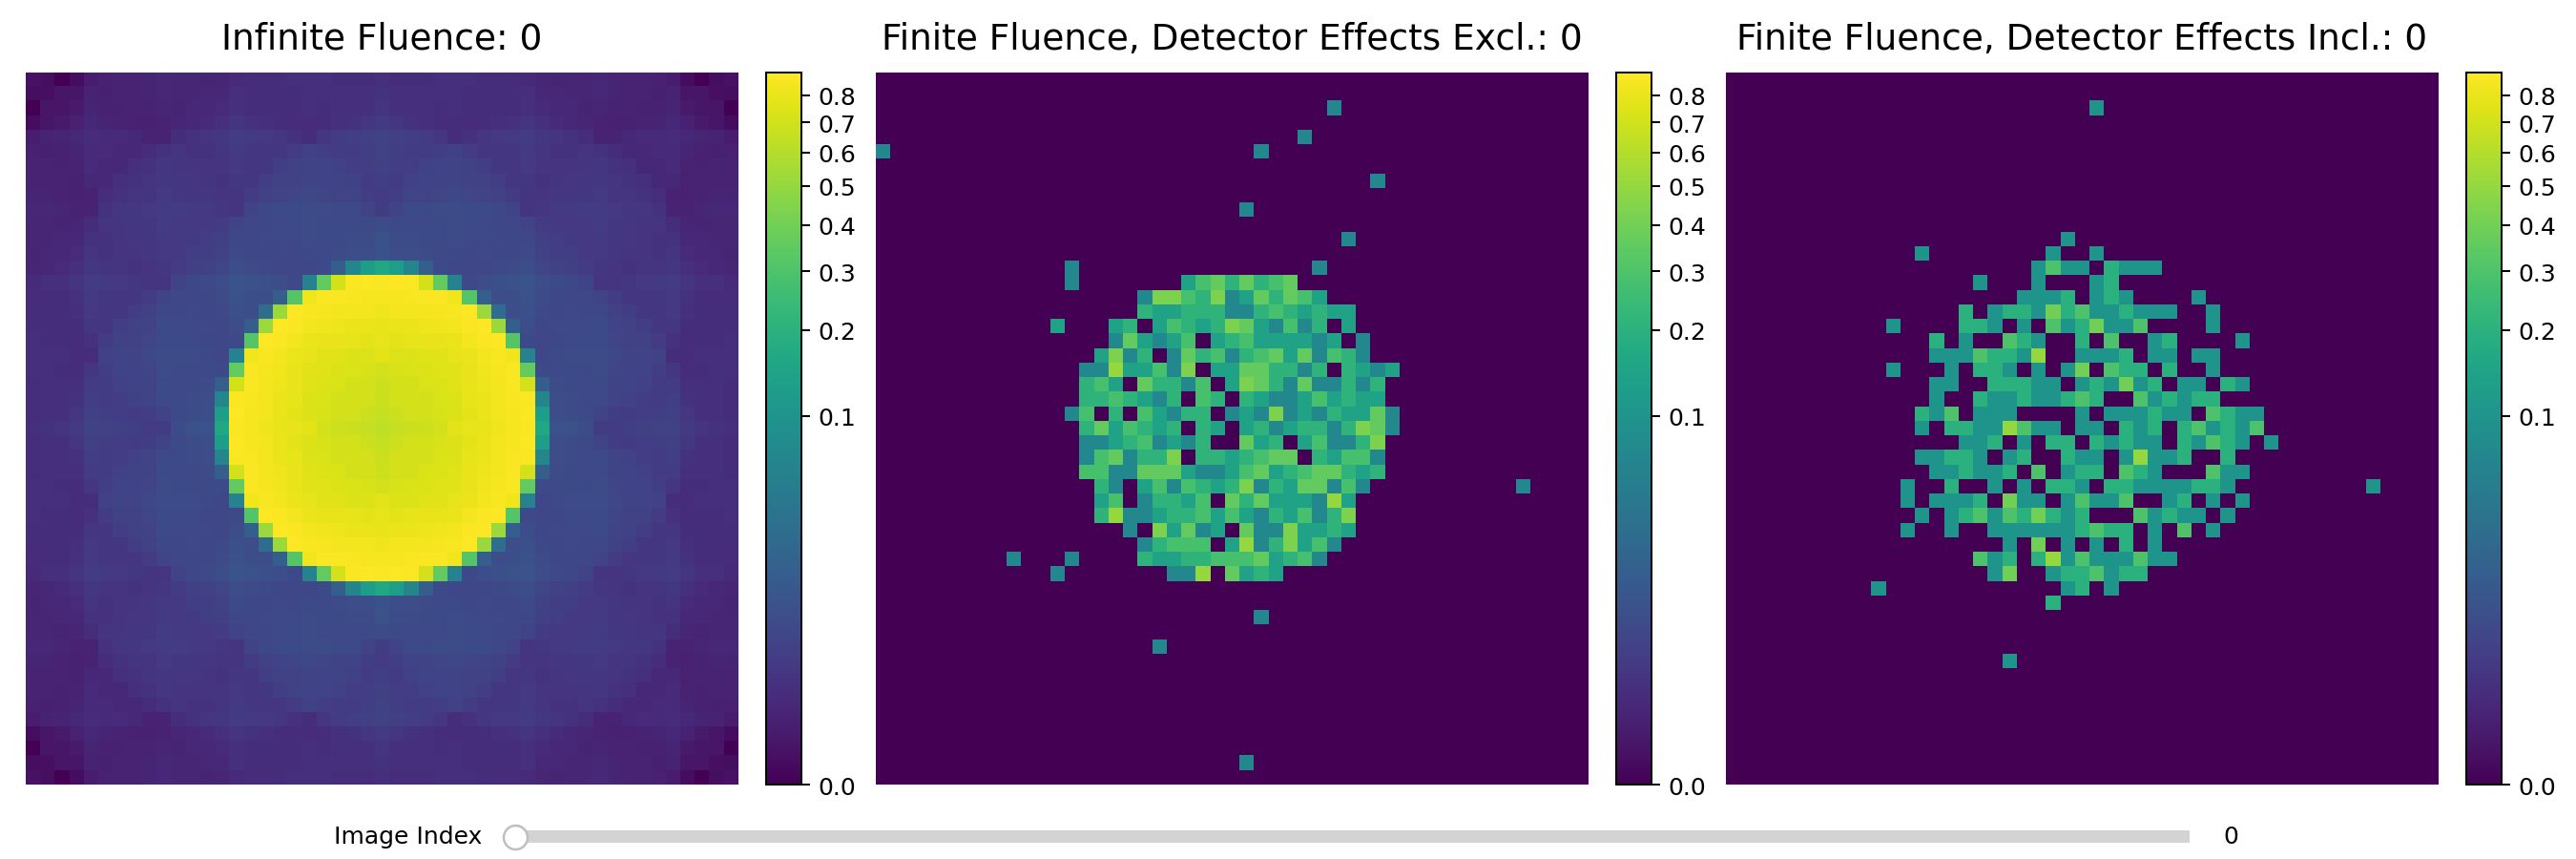

/tmp/ipykernel_610561/1837688818.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [65]:
%matplotlib nbagg
import h5py 
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
from matplotlib import colors

def update_image(val):
    index = int(val)
    
    arr1_normalized = (arr1[index, index] - vmins[0]) / (vmaxs[0] - vmins[0])
    arr2_normalized = (arr2[index, index] - vmins[1]) / (vmaxs[1] - vmins[1])
    arr3_normalized = (arr3[index, index] - vmins[2]) / (vmaxs[2] - vmins[2])
    
    ax1.imshow(arr1_normalized, cmap='viridis', norm = norm)
    ax2.imshow(arr2_normalized, cmap='viridis', norm = norm)
    ax3.imshow(arr3_normalized, cmap='viridis', norm = norm)
    
    ax1.set_title(f"Infinite Dose Input Image: {index}")
    ax2.set_title(f"Finite Dose, Detector Effects Excluded: {index}")
    ax3.set_title(f"Finite Dose, Detector Effects Included: {index}")
    fig.canvas.draw_idle()

file1 = input_hdf5_filename
file2 = doseapplied_hdf5_filename
file3 = output_hdf5_filename
f1 = h5py.File(file1, 'r')
f2 = h5py.File(file2, 'r')
f3 = h5py.File(file3, 'r')
arr1 = f1['array']
arr2 = f2['array']
arr3 = f3['array']

# Calculate vmin and vmax for each image
vmins = [np.min(arr1), np.min(arr2), np.min(arr3)]
vmaxs = [np.max(arr1), np.max(arr2), np.max(arr3)]

# Initial index for the slider
initial_index = 0
fontsize=15
pad = 10
# Power normalization with gamma=0.5
norm = colors.PowerNorm(gamma=.3)


# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display initial images
arr1_normalized = (arr1[initial_index, initial_index] - vmins[0]) / (vmaxs[0] - vmins[0])
arr2_normalized = (arr2[initial_index, initial_index] - vmins[1]) / (vmaxs[1] - vmins[1])
arr3_normalized = (arr3[initial_index, initial_index] - vmins[2]) / (vmaxs[2] - vmins[2])

im1 = axes[0].imshow(arr1_normalized, cmap='viridis', norm=norm)
im2 = axes[1].imshow(arr2_normalized, cmap='viridis', norm=norm)
im3 = axes[2].imshow(arr3_normalized, cmap='viridis', norm=norm)

# Set titles for each subplot
axes[0].set_title(f"Infinite Fluence: {initial_index}", fontsize=fontsize, pad=pad)
axes[1].set_title(f"Finite Fluence, Detector Effects Excl.: {initial_index}", fontsize=fontsize, pad=pad)
axes[2].set_title(f"Finite Fluence, Detector Effects Incl.: {initial_index}", fontsize=fontsize, pad=pad)

# Create a slider widget
ax_slider = plt.axes([0.2, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Image Index', 0, arr1.shape[0] - 1, valinit=initial_index, valstep=1)

cax1 = axes[0].inset_axes([1.04, 0.0, 0.05, 1])
fig.colorbar(im1, ax=axes[0], cax=cax1)

cax2 = axes[1].inset_axes([1.04, 0.0, 0.05, 1])
fig.colorbar(im1, ax=axes[1], cax=cax2)

cax3 = axes[2].inset_axes([1.04, 0.0, 0.05, 1])
fig.colorbar(im1, ax=axes[2], cax=cax3)

# Update images based on slider value
slider.on_changed(update_image)

# Adjust spacing between subplots
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.98, wspace=0.3, hspace=0.3)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
plt.tight_layout()


subfolder_path = os.path.join(parent_folder, 'ExamplePatterns')
os.makedirs(subfolder_path, exist_ok=True)

# Save as PNG, TIFF, and SVG
output_file_path_png = os.path.join(subfolder_path, 'example_patterns.png')
output_file_path_tiff = os.path.join(subfolder_path, 'example_patterns.tiff')
output_file_path_svg = os.path.join(subfolder_path, 'example_patterns.svg')

plt.savefig(output_file_path_png, dpi=300)
plt.savefig(output_file_path_tiff, dpi=300)
plt.savefig(output_file_path_svg)

plt.show()
